In [39]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import warnings
import sys, os
import seaborn as sns
import math as m


## Helper Functions

In [113]:
temp_stdout = None

# Disable
def blockPrint():
    global temp_stdout
    temp_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    global temp_stdout
    sys.stdout = temp_stdout

In [9]:
def get_opt_model(returns, max_p, max_q, metric="AIC", model_type="GARCH"):
    min_metric = float('inf')
    opt_p_q = []
    metric_mat = np.zeros((max_p, max_q))
    for p in range(1, max_p+1):
        for q in range(1, max_p+1):
            model = arch_model(returns, p=p, q=q, vol=model_type)
            model_fit = model.fit()
            if metric == "AIC":
                aic = model_fit.aic
                metric_mat[p-1, q-1] = round(aic, 1)
                if aic < min_metric:
                    min_metric = aic
                    opt_p_q = [p, q]
            elif metric == "BIC":
                bic = model_fit.bic
                metric_mat[p-1, q-1] = round(bic, 1)
                if bic < min_metric:
                    min_metric = bic
                    opt_p_q = [p, q]
                    
    return opt_p_q[0], opt_p_q[1], metric_mat

In [10]:
def heatmap(mat, model_type, metric):
    plt.clf()
    heatmap = sns.heatmap(mat, 
                          # cmap=color_scheme,
                          xticklabels=range(1, mat.shape[0]+1),
                          yticklabels=range(1, mat.shape[0]+1), 
                          vmin=np.min(mat), 
                          vmax=np.max(mat))
    heatmap.set_title(f"{metric} Heatmap")
    heatmap.set(xlabel = f"{model_type} q values", ylabel = "GARCH p values")
    plt.show()

In [42]:
def rolling_predictions(returns, opt_p, opt_q, model_type="GARCH", method_type="analytic"):
    warnings.filterwarnings('ignore')
    rolling_predictions = []
    test_size = 365*5

    for i in range(test_size):
        train = returns[:-(test_size-i)]
        model = arch_model(train, p=opt_p, q=opt_q, vol=model_type)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1, method=method_type)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
        
    rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365*5:])

    plt.figure(figsize=(10,4))
    true, = plt.plot(returns[-365*5:])
    preds, = plt.plot(rolling_predictions)
    plt.title(f'{model_type} Volatility Prediction - Rolling Forecast', fontsize=20)
    plt.legend(['Returns', 'Predicted Volatility'], fontsize=16)
    
    return rolling_predictions

In [70]:
def long_prediction(model, returns, num_test_days, opt_p, opt_q, rolling_preds, model_type="GARCH", method_type="analytic"):
    
    # THOUGHTS:
    # i don't think this is dont correctly since the 30-day and rolling forecast yield the same volatility
    # not sure what we are supposed to compare the 30-day forecast with?
    # how do we calculate the RMSE and MAE? like what are we using as a comparison volatility? 
    # if i'm not mistaken, the article from the link below says that volatility can't be measured point-wise
    # found this (not sure if its helpful): https://stats.stackexchange.com/questions/205562/evaluate-forecasting-ability-of-garch-models-with-rmse-and-mae 
    # quote from the link above: "The problem with such error metrics is that volatility is not an observable thing, and it depends on the model. 
    # Hence the error is not something well defined (compare what with what?)"

    train = returns[:-num_test_days]
    model = arch_model(train, p=opt_p, q=opt_q, vol=model_type)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=num_test_days, method=method_type)
    test_dates = returns.index[len(returns)-num_test_days:]
    pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=test_dates)
    
    return pred

In [161]:
def calc_errors(returns, rolling_preds, long_preds, num_test_days, model_type, data_type):
    
    realized_vol_long = returns.rolling(window=num_test_days).std(ddof=0)#*np.sqrt(252)
    realized_vol_rolling = returns.rolling(window=3).std(ddof=0)#*np.sqrt(252)

    realized_vol_long_test = realized_vol_long[-num_test_days:]
    realized_vol_rolling_test = realized_vol_rolling[-num_test_days:]
    rolling_preds_test = rolling_preds[-num_test_days:]

    # rmse_real_rolling = np.sqrt(np.mean((rolling_preds_test - realized_vol_rolling_test)**2))
    # print(f"\nRealized rolling vol vs rolling vol forecast RMSE = {np.round(rmse_real_rolling, 2)}")
    
    # plt.figure(figsize=(10,4))
    # plt.plot(rolling_preds_test, label=f"rolling predictions", linewidth=2)
    # plt.plot(realized_vol_rolling_test, label=f"realized rolling volatility", linewidth=2)
    # plt.legend(loc="lower left")
    # plt.title(f'{model_type} Volatility Model: Rolling Predictions & Realized Volatility', fontsize=16)
    
    rmse_real_long = np.sqrt(np.mean((long_preds - realized_vol_long_test)**2))
    print(f"Realized {num_test_days}-day vol vs {num_test_days}-day vol forecast RMSE = {np.round(rmse_real_long, 2)}")
    
    rmse_real_rolling = np.sqrt(np.mean((rolling_preds_test - realized_vol_long_test)**2))
    print(f"Realized {num_test_days}-day vol vs rolling vol forecast RMSE = {np.round(rmse_real_rolling, 2)}")
    
    rmse_rolling_long = np.sqrt(np.mean((rolling_preds_test - long_preds)**2))
    print(f"Rolling forecast vs {num_test_days}-day forecast RMSE = {np.round(rmse_rolling_long, 2)}")

    plt.figure(figsize=(10,4))
    plt.plot(long_preds, label=f"{num_test_days}-day predictions", linewidth=2)
    plt.plot(realized_vol_long_test, label=f"{num_test_days}-day realized volatility", linewidth=2)
    plt.plot(rolling_preds_test, label=f"rolling predictions", linewidth=2)
    lims = (1, 3.25) if "futures" else (0.75, 3.25)
    plt.ylim(lims)
    plt.legend(loc="upper left")
    plt.title(f'{model_type} Volatility Model: {num_test_days}-Day Prediction, Rolling Prediction, Realized Volatility', fontsize=16)
    
    return realized_vol_long, realized_vol_rolling

In [157]:
def train_metrics(returns, model_type, metric, max_p, max_q, long_forecast_horizon=21, fixed_pq = None, data_type=None):
    
    blockPrint()
    opt_p, opt_q, aic_mat = get_opt_model(returns, max_p, max_q, metric, model_type)
    if fixed_pq:
        opt_p, opt_q = fixed_pq[0], fixed_pq[1]
        
    opt_model = arch_model(returns, p=opt_p, q=opt_q, vol=model_type).fit()
    enablePrint()
    
    print(f"{metric} matrix: \n{aic_mat}")
    heatmap(aic_mat, model_type, metric)

    print(f"\n--- {model_type}({opt_p}, {opt_q}) ---")
    print(opt_model.summary())
    
    method_type = "simulation" if model_type == "EGARCH" else "analytic"
    rolling_preds = rolling_predictions(returns, opt_p, opt_q, model_type=model_type, method_type=method_type)
    long_preds = long_prediction(opt_model, returns, long_forecast_horizon, opt_p, opt_q, rolling_preds, model_type=model_type, method_type=method_type)
    
    realized_vol_long, realized_vol_rolling = calc_errors(returns, rolling_preds, long_preds, long_forecast_horizon, model_type, data_type)
    
    plt.figure(figsize=(10,4))
    plt.plot(returns)
    plt.plot(realized_vol_long)
    plt.title(f'{model_type} Volatility Prediction - {long_forecast_horizon}-Day Realized Vol', fontsize=20)
    plt.legend(['Returns', f'{long_forecast_horizon}-Day Realized Volatility'], fontsize=16)
    
    # plt.figure(figsize=(10,4))
    # plt.plot(returns)
    # plt.plot(realized_vol_rolling)
    # plt.title(f'{model_type} Volatility Prediction - Realized Rolling Vol', fontsize=20)
    # plt.legend(['Returns', 'Realized Rolling Volatility'], fontsize=16)    

# __________________________________________________________

## Load S&P 500 Data

In [153]:
start = datetime(2012, 11, 11)
end = datetime(2022, 11, 11)
spy = web.DataReader('SPY', 'yahoo', start=start, end=end)
returns = 100 * spy.Close.pct_change().dropna()
# returns = np.log(1 + returns)
returns

Date
2012-11-13   -0.347155
2012-11-14   -1.349881
2012-11-15   -0.169202
2012-11-16    0.493735
2012-11-19    2.023913
                ...   
2022-11-07    0.956558
2022-11-08    0.539541
2022-11-09   -2.060208
2022-11-10    5.495415
2022-11-11    0.967850
Name: Close, Length: 2518, dtype: float64

## Plot Data

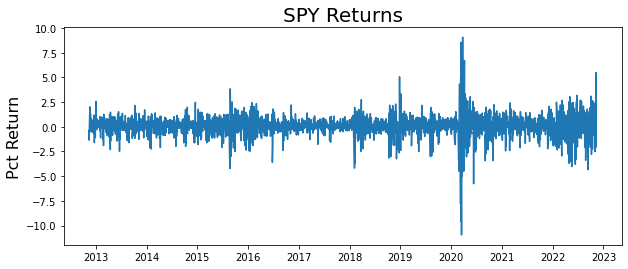

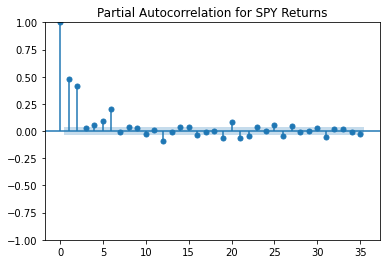

In [154]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('SPY Returns', fontsize=20)
plot_pacf(returns**2, title="Partial Autocorrelation for SPY Returns")
plt.show()

## Analyze Data: GARCH

### GARCH AIC & BIC

AIC matrix: 
[[6261.5 6263.5 6265.5 6267.5 6269.5 6271.4 6272.9]
 [6263.2 6264.3 6266.3 6268.3 6270.3 6272.3 6273.7]
 [6264.4 6266.4 6267.4 6269.4 6270.6 6272.  6272.5]
 [6266.4 6265.4 6267.  6268.8 6268.1 6269.5 6269.1]
 [6268.4 6267.4 6269.  6270.8 6270.1 6271.5 6271.1]
 [6270.4 6269.4 6270.7 6272.3 6272.1 6273.2 6271.3]
 [6272.4 6271.4 6272.7 6274.3 6274.1 6275.2 6273.3]]


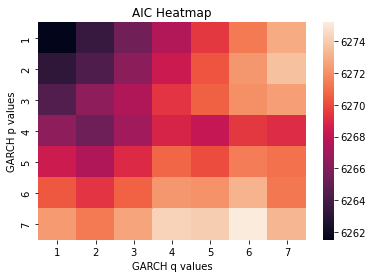


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3126.76
Distribution:                  Normal   AIC:                           6261.52
Method:            Maximum Likelihood   BIC:                           6284.84
                                        No. Observations:                 2518
Date:                Mon, Dec 12 2022   Df Residuals:                     2517
Time:                        23:10:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0855  1.399e-02      6.111

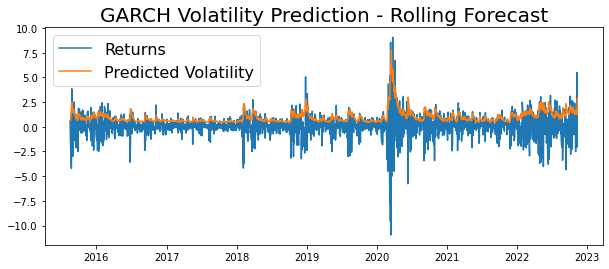

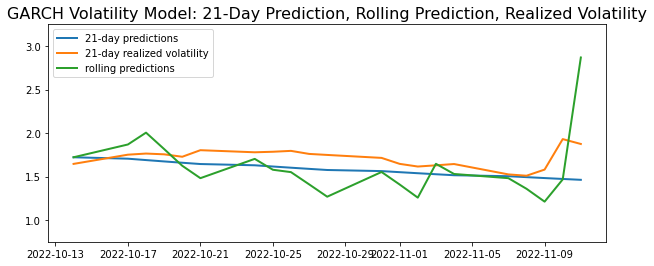

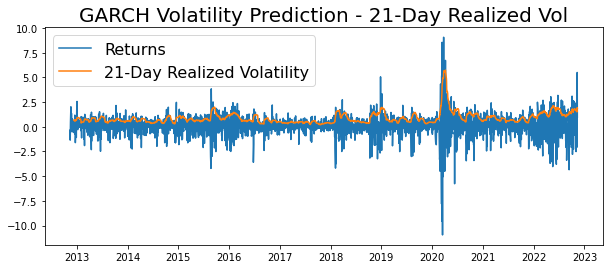

In [155]:
train_metrics(returns=returns, model_type="GARCH", metric="AIC", max_p=7, max_q=7)

BIC matrix: 
[[6284.8 6292.7 6300.5 6308.3 6316.2 6323.9 6331.2]
 [6292.3 6299.3 6307.1 6314.9 6322.7 6330.6 6337.8]
 [6299.4 6307.2 6314.1 6321.9 6328.9 6336.2 6342.5]
 [6307.3 6312.  6319.4 6327.1 6332.2 6339.5 6344.9]
 [6315.1 6319.9 6327.3 6334.9 6340.  6347.3 6352.7]
 [6322.9 6327.7 6334.8 6342.2 6347.9 6354.8 6358.7]
 [6330.7 6335.5 6342.6 6350.1 6355.7 6362.6 6366.6]]


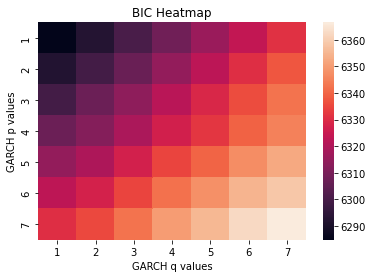


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3126.76
Distribution:                  Normal   AIC:                           6261.52
Method:            Maximum Likelihood   BIC:                           6284.84
                                        No. Observations:                 2518
Date:                Sun, Dec 11 2022   Df Residuals:                     2517
Time:                        23:25:03   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0855  1.399e-02      6.111

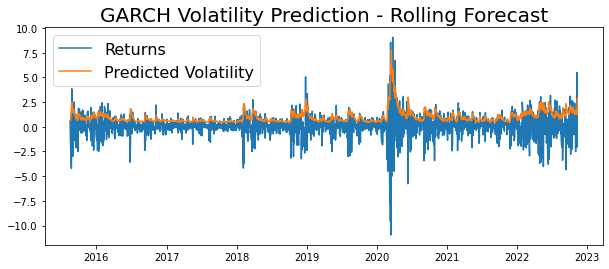

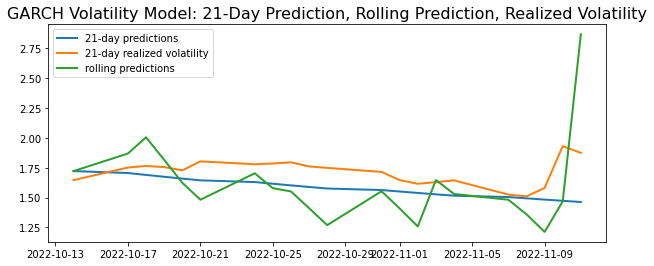

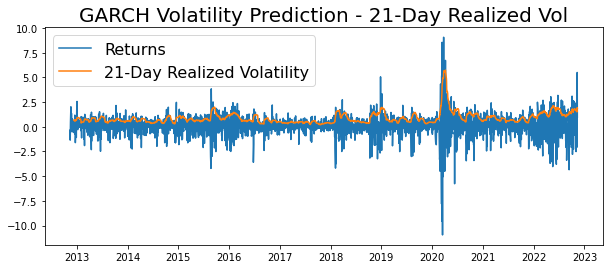

In [105]:
train_metrics(returns=returns, model_type="GARCH", metric="BIC", max_p=7, max_q=7)

### EGARCH AIC & BIC

AIC matrix: 
[[6282.5 6284.5 6286.5 6288.5 6289.5 6291.  6291.5]
 [6284.2 6281.7 6283.  6285.  6286.1 6288.  6288.3]
 [6286.2 6283.1 6287.3 6289.1 6290.8 6292.8 6291.2]
 [6287.7 6283.5 6284.2 6286.1 6282.4 6281.3 6282.2]
 [6272.6 6274.3 6276.3 6278.3 6280.3 6282.5 6283.8]
 [6274.5 6275.1 6277.1 6279.1 6281.1 6283.1 6282.1]
 [6271.  6273.  6274.5 6276.5 6278.5 6281.3 6283.3]]


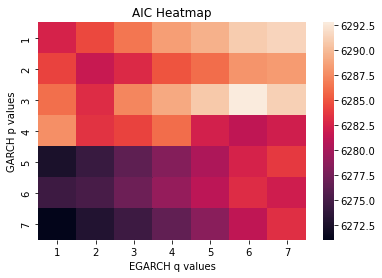


--- EGARCH(7, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3125.48
Distribution:                  Normal   AIC:                           6270.97
Method:            Maximum Likelihood   BIC:                           6329.28
                                        No. Observations:                 2518
Date:                Mon, Dec 12 2022   Df Residuals:                     2517
Time:                        14:14:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0935  8.439e-04    

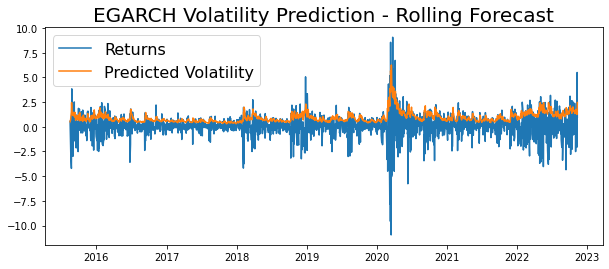

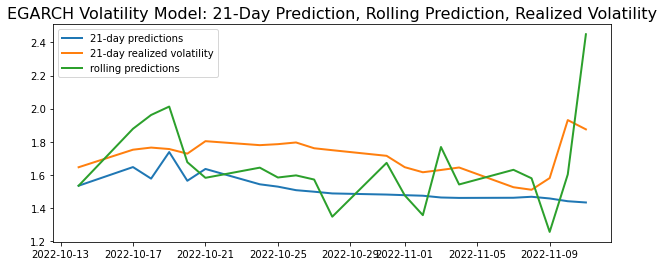

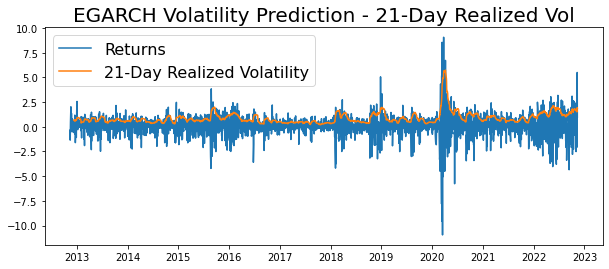

In [109]:
train_metrics(returns=returns, model_type="EGARCH", metric="AIC", max_p=7, max_q=7)

BIC matrix: 
[[6305.8 6313.6 6321.5 6329.3 6336.2 6343.5 6349.8]
 [6313.3 6316.7 6323.8 6331.7 6338.6 6346.3 6352.5]
 [6321.2 6324.  6334.  6341.6 6349.1 6356.9 6361.1]
 [6328.5 6330.2 6336.7 6344.4 6346.6 6351.3 6358. ]
 [6319.2 6326.8 6334.6 6342.4 6350.3 6358.3 6365.4]
 [6327.  6333.4 6341.2 6349.  6356.9 6364.7 6369.5]
 [6329.3 6337.1 6344.5 6352.3 6360.2 6368.8 6376.6]]


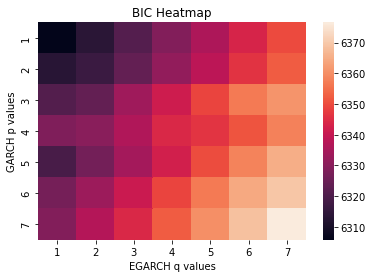


--- EGARCH(1, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3137.23
Distribution:                  Normal   AIC:                           6282.47
Method:            Maximum Likelihood   BIC:                           6305.79
                                        No. Observations:                 2518
Date:                Mon, Dec 12 2022   Df Residuals:                     2517
Time:                        21:17:36   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0957  1.435e-02      6.66

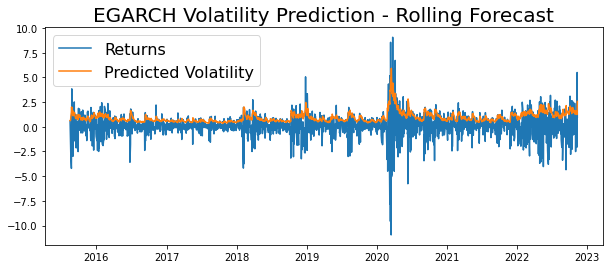

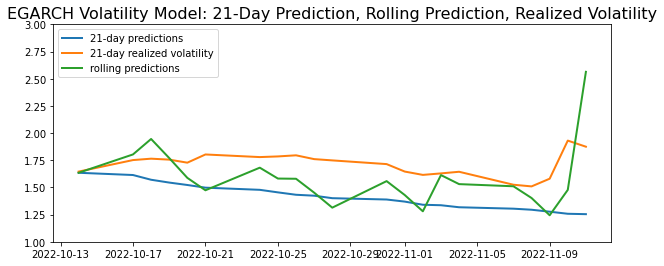

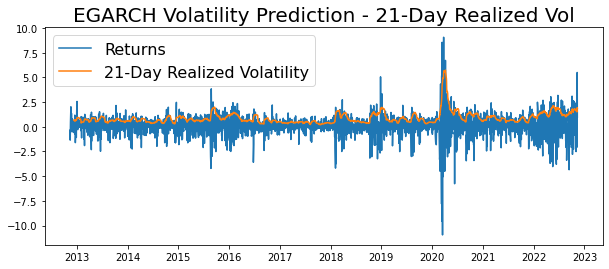

In [120]:
train_metrics(returns=returns, model_type="EGARCH", metric="BIC", max_p=7, max_q=7)

# __________________________________________________________

## Load S&P 500 Futures Data

In [158]:
df_futures = pd.read_csv("FuturesData.csv")
df_futures = df_futures[['Date', 'Price', 'Change %']]
# df_futures['Price'] = [float(x.replace(',', '')) for x in df_futures['Price']]
df_futures['Change %'] = [float(x.strip('%')) for x in df_futures['Change %']]
df_futures['Date'] = pd.to_datetime(df_futures['Date'])
returns_futures = df_futures["Change %"]
returns_futures.index = df_futures['Date']
returns_futures = returns_futures.sort_index(ascending=True)
returns_futures = returns_futures[:-16]
returns_futures

Date
2012-11-12    0.18
2012-11-13   -0.53
2012-11-14   -1.31
2012-11-15   -0.13
2012-11-16    0.63
              ... 
2022-11-07    0.95
2022-11-08    0.52
2022-11-09   -2.08
2022-11-10    5.47
2022-11-11    0.99
Name: Change %, Length: 2547, dtype: float64

## Visualize Futures Data

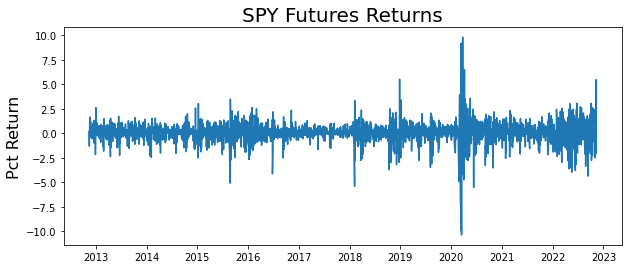

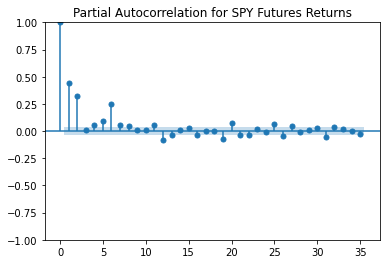

In [159]:
plt.figure(figsize=(10,4))
plt.plot(returns_futures)
plt.ylabel('Pct Return', fontsize=16)
plt.title('SPY Futures Returns', fontsize=20)
plot_pacf(returns_futures**2, title="Partial Autocorrelation for SPY Futures Returns")
plt.show()

## Analyze Futures Data: GARCH

### GARCH AIC & BIC

AIC matrix: 
[[6293.5 6295.5 6297.5 6299.5 6301.5 6303.5 6305.4]
 [6294.8 6296.  6298.  6300.  6302.  6304.  6305.9]
 [6295.5 6297.5 6299.8 6301.5 6303.8 6305.8 6305.9]
 [6294.8 6293.9 6294.4 6296.4 6296.5 6298.5 6300.1]
 [6296.8 6295.9 6296.4 6298.4 6298.5 6300.5 6302.1]
 [6298.8 6297.9 6298.4 6300.4 6300.5 6302.3 6304. ]
 [6300.8 6299.9 6300.3 6302.4 6302.5 6304.3 6306. ]]


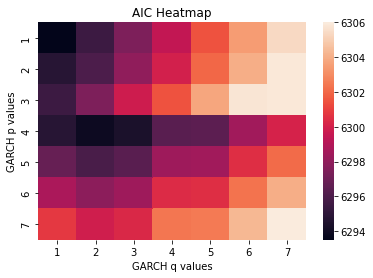


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3142.77
Distribution:                  Normal   AIC:                           6293.54
Method:            Maximum Likelihood   BIC:                           6316.91
                                        No. Observations:                 2547
Date:                Mon, Dec 12 2022   Df Residuals:                     2546
Time:                        23:16:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0900  1.404e-02      6.410

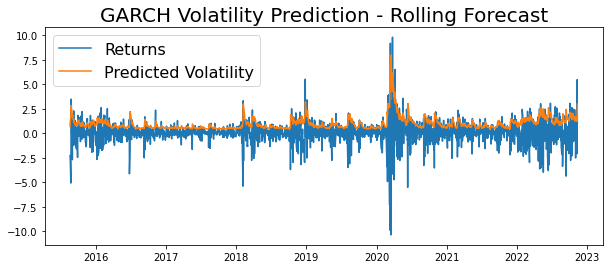

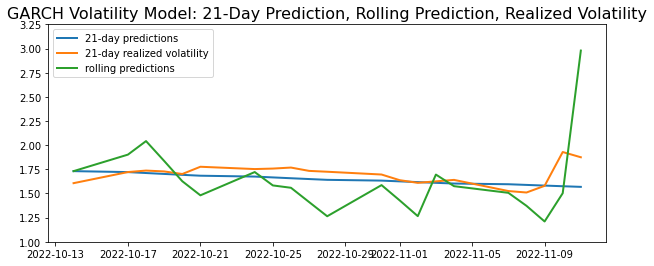

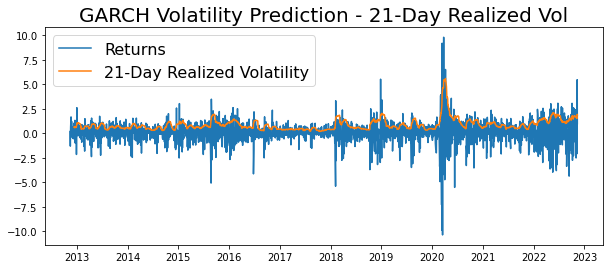

In [162]:
train_metrics(returns=returns_futures, model_type="GARCH", metric="AIC", max_p=7, max_q=7, data_type="futures")

BIC matrix: 
[[6316.9 6324.7 6332.6 6340.4 6348.3 6356.1 6363.9]
 [6324.  6331.1 6338.9 6346.7 6354.6 6362.4 6370.2]
 [6330.5 6338.4 6346.5 6354.1 6362.2 6370.  6376. ]
 [6335.7 6340.7 6347.  6354.9 6360.8 6368.6 6376.1]
 [6343.6 6348.5 6354.9 6362.7 6368.6 6376.4 6383.9]
 [6351.4 6356.3 6362.7 6370.5 6376.5 6384.1 6391.6]
 [6359.3 6364.1 6370.4 6378.4 6384.3 6391.9 6399.4]]


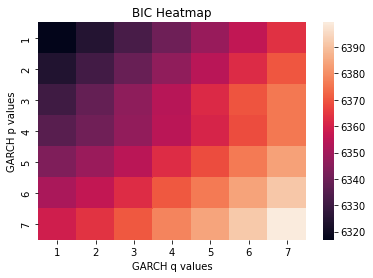


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3142.77
Distribution:                  Normal   AIC:                           6293.54
Method:            Maximum Likelihood   BIC:                           6316.91
                                        No. Observations:                 2547
Date:                Mon, Dec 12 2022   Df Residuals:                     2546
Time:                        23:18:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0900  1.404e-02      6.410

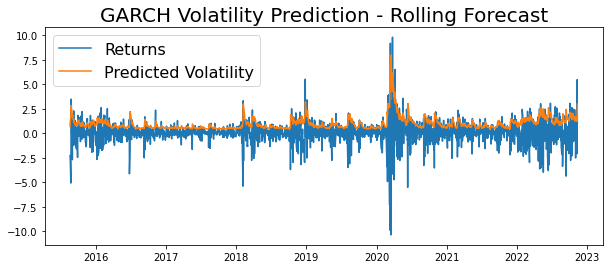

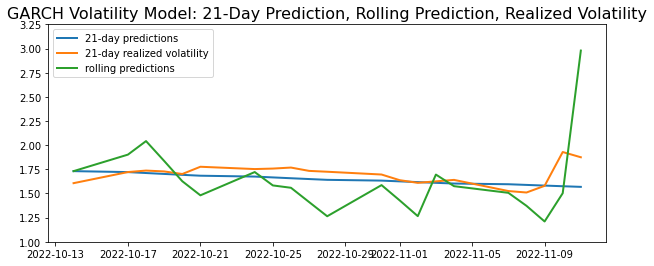

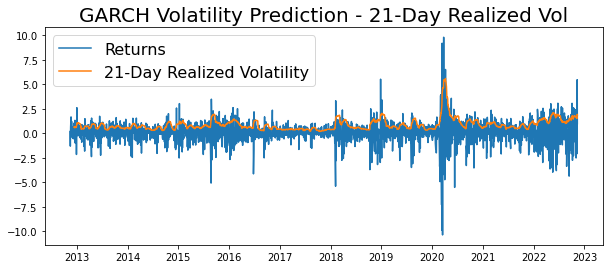

In [163]:
train_metrics(returns=returns_futures, model_type="GARCH", metric="BIC", max_p=7, max_q=7)

### EGARCH AIC & BIC

AIC matrix: 
[[6322.7 6324.7 6326.7 6328.7 6330.2 6332.  6332.9]
 [6324.4 6321.6 6323.  6325.  6327.  6328.4 6330.4]
 [6326.4 6323.1 6325.  6323.3 6324.8 6326.8 6328.8]
 [6328.3 6322.6 6316.5 6318.5 6321.5 6320.1 6321.4]
 [6314.  6315.4 6313.5 6315.5 6317.5 6319.5 6320.9]
 [6315.8 6317.3 6319.3 6317.3 6319.3 6318.5 6320.5]
 [6312.4 6314.5 6314.4 6316.4 6318.4 6320.4 6322.4]]


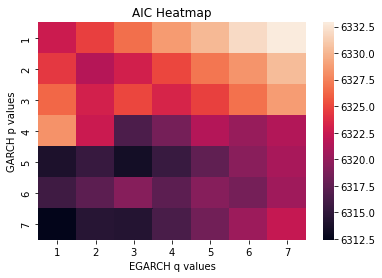


--- EGARCH(7, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3146.21
Distribution:                  Normal   AIC:                           6312.42
Method:            Maximum Likelihood   BIC:                           6370.85
                                        No. Observations:                 2547
Date:                Mon, Dec 12 2022   Df Residuals:                     2546
Time:                        23:26:17   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1034  1.524e-02      6.78

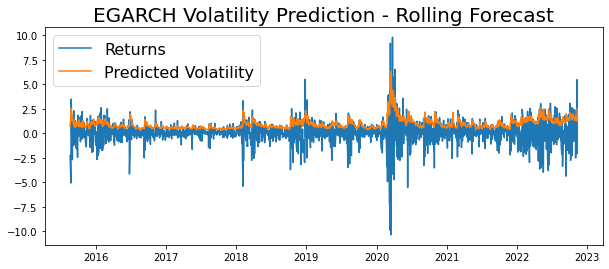

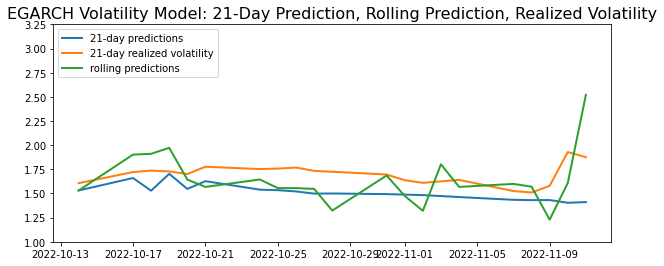

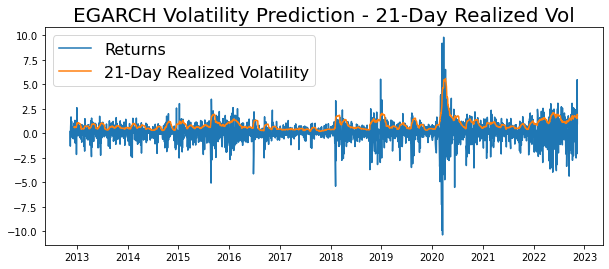

In [164]:
train_metrics(returns=returns_futures, model_type="EGARCH", metric="AIC", max_p=7, max_q=7)

BIC matrix: 
[[6346.  6353.9 6361.7 6369.6 6377.  6384.6 6391.3]
 [6353.6 6356.7 6363.9 6371.7 6379.6 6386.9 6394.7]
 [6361.5 6364.  6371.7 6375.9 6383.3 6391.1 6399. ]
 [6369.2 6369.4 6369.1 6376.9 6385.7 6390.2 6397.4]
 [6360.7 6368.  6371.9 6379.8 6387.6 6395.4 6402.7]
 [6368.4 6375.7 6383.5 6387.4 6395.3 6400.3 6408.1]
 [6370.8 6378.8 6384.5 6392.4 6400.2 6408.1 6415.9]]


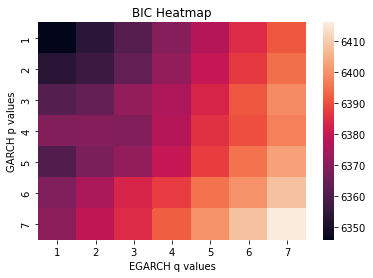


--- EGARCH(1, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3157.33
Distribution:                  Normal   AIC:                           6322.67
Method:            Maximum Likelihood   BIC:                           6346.04
                                        No. Observations:                 2547
Date:                Mon, Dec 12 2022   Df Residuals:                     2546
Time:                        23:42:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1063  1.474e-02      7.20

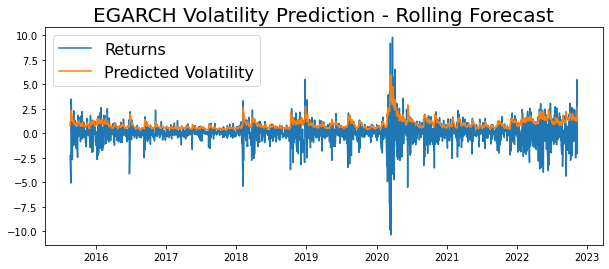

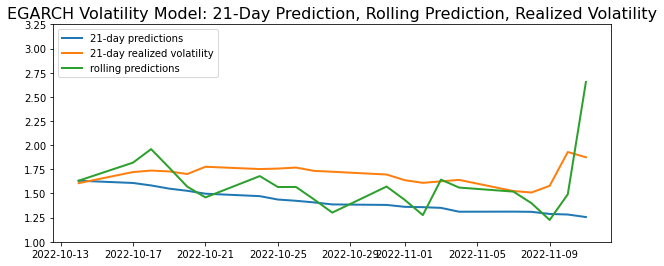

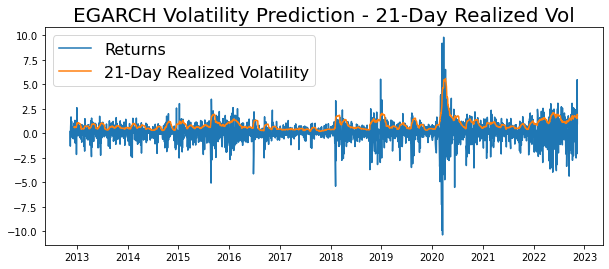

In [165]:
train_metrics(returns=returns_futures, model_type="EGARCH", metric="BIC", max_p=7, max_q=7)